# Лабораторная 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from PIL import Image
from torchvision import transforms as tfs
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

## 1. Обучение Нейронной сети

### Градиентный спуск

Вспомним в чём заключается суть градиентного спуска в минимизации функции потерь.

Предположим, у нас есть функция потерь $L(w)$, где $w$ - это вектор параметров, который мы хотим оптимизировать. Наша цель - минимизировать эту функцию потерь путем изменения параметров $w$. Градиентный спуск осуществляет это изменение, используя градиент функции потерь.

Шаги градиентного спуска выглядят следующим образом:

1. Инициализируем параметры $w$ случайными значениями или нулями.
2. Для каждой итерации $t$ обновляем параметры по формуле:
$$w^{(t+1)} = w^{(t)} - \alpha \nabla L(w^{(t)})$$
Где $\alpha$ - это ***коэффициент обучения (learning rate)***, который определяет размер шага, а $\nabla L(w^{(t)})$ - градиент функции потерь по параметрам $w$.

Градиент вычисляется как вектор частных производных функции потерь по каждому элементу $w$, и он показывает направление наискорейшего роста функции потерь.

Формула для вычисления градиента в точке $w$:
$$\nabla L(w) = \left[ \frac{\partial L(w)}{\partial w_1}, \frac{\partial L(w)}{\partial w_2}, ..., \frac{\partial L(w)}{\partial w_l} \right]$$

Где каждая частная производная $\frac{\partial L(w)}{\partial w_i}$ вычисляется отдельно для каждого параметра $w_i$.

После вычисления градиента мы обновляем параметры модели, вычитая градиент, умноженный на коэффициент обучения. Этот процесс повторяется до тех пор, пока изменения параметров остаются незначительными или до тех пор, пока функция потерь не минимизируется в нужной степени.

Таким образом, градиентный спуск представляет собой мощный метод оптимизации, который позволяет находить оптимальные параметры модели путем минимизации функции потерь.

Обучение нейронной сети осуществляется с помощью обратного распространения ошибки.

***Метод обратного распространения ошибки (backpropagation)*** является ключевым алгоритмом для обучения нейронных сетей. Он используется для вычисления градиента функции потерь по отношению к весам нейронной сети, что позволяет оптимизировать эти веса с использованием методов градиентного спуска или его модификаций.

Алгоритм backpropagation:

1. Прямое распространение (forward pass):
Входные данные пропускаются через нейронную сеть, и каждый нейрон вычисляет своё значение активации, используя входные данные, веса и функцию активации. Значения активаций передаются от слоя к слою до получения вывода сети.

2. Обратное распространение (backpropagation):
a. Рассчитывается ошибка предсказания, выраженная функцией потерь (например, среднеквадратичная ошибка для задачи регрессии или кросс-энтропия для задачи классификации).
b. Вычисляется градиент функции потерь по отношению к каждому весу в нейронной сети с использованием метода автоматического дифференцирования и правила цепи (chain rule) из дифференциального исчисления.
c. Этот градиент "пропускается" через сеть в обратном направлении, чтобы рассчитать градиенты функции потерь по отношению к выходу каждого нейрона в скрытых слоях сети.

3. Градиентный спуск (gradient descent):
Расчитанные градиенты используются для обновления весов нейронной сети с целью минимизировать функцию потерь. Это можно делать при помощи методов градиентного спуска, таких как стохастический градиентный спуск (SGD), адаптивные методы оптимизации (например, Adam, RMSprop и т. д.).

## 1.2 Кросс-энтропия

Для случая ***бинарной классификации*** с двумя классами, кросс-энтропия рассчитывается следующим образом:

$H(y, \hat{y}) = - (y \log \hat{y} + (1 - y) \log(1 - \hat{y}))$

где:
- $y$ - реальное значение (0 или 1),
- $\hat{y}$ - предсказанная вероятность отнесения к классу 1.

В случае ***многоклассовой классификации***, кросс-энтропия рассчитывается по формуле:

$H(y, \hat{y}) = - \sum_{i} y(i) \log \hat{y}(i)$

где:
- $y(i)$ - индикаторная функция, равная 1, если объект относится к классу i и 0 в противном случае,
- $\hat{y}(i)$ - вероятность, предсказанная моделью, отнесения объекта к классу i.

### Задача 1(1 балл)

Напишите функцию, реализующую кросс-энтропию.

Чему равен градиент кросс-энтропии.

In [6]:
y = [np.random.choice([0, 1]) for i in range (10)]
yhat = [np.random.rand() for i in range (10)]
H = 0
for i in range (10):
  H += - y[i] * np.log(yhat[i])
H

4.878702183912813

## 2. Dropout

***Dropout*** - это техника регуляризации, которая используется в нейронных сетях для предотвращения переобучения. Она заключается в том, чтобы случайным образом убирать некоторые нейроны во время обучения.

Во время каждой итерации обучения случайно выбираются нейроны, которые ***будут удалены*** и не будут участвовать в обучении на данной итерации.

Такой подход помогает сети избегать переобучения и улучшает ее обобщающую способность. После обучения все нейроны восстанавливаются, и в процессе тестирования сети все нейроны работают.

In [7]:
# Рассмотрим датасет MNIST
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=1000)

100%|██████████| 9912422/9912422 [00:00<00:00, 87504417.23it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 10556487.48it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23283085.82it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4918804.23it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Рассмотрим архитектуру нейронной сети, в которой присутствует Dropout. **"Отключение" нейронов** можно осуществлять с помощью метода ***torch.nn.Dropout()***.

На самом деле архитектура ниже, созданная с помощью ***nn.Sequential***, уже не выглядит компактной с точки зрения Python. Позже мы рассмотрим, как записывать подобные архитектуры более компактно.

In [8]:
activation = nn.Tanh()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.1),
    nn.Linear(256, 128),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.1),
    nn.Linear(128, 64),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.1),
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

In [9]:
# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.87525
Loader: valid. Accuracy: 0.9279
Epoch: 2
Loader: train. Accuracy: 0.93955
Loader: valid. Accuracy: 0.9525
Epoch: 3
Loader: train. Accuracy: 0.9516
Loader: valid. Accuracy: 0.9562
Epoch: 4
Loader: train. Accuracy: 0.9598666666666666
Loader: valid. Accuracy: 0.963
Epoch: 5
Loader: train. Accuracy: 0.9625
Loader: valid. Accuracy: 0.9657
Epoch: 6
Loader: train. Accuracy: 0.9651
Loader: valid. Accuracy: 0.9693
Epoch: 7
Loader: train. Accuracy: 0.9689166666666666
Loader: valid. Accuracy: 0.9704
Epoch: 8
Loader: train. Accuracy: 0.9696333333333333
Loader: valid. Accuracy: 0.969
Epoch: 9
Loader: train. Accuracy: 0.9707166666666667
Loader: valid. Accuracy: 0.9719
Epoch: 10
Loader: train. Accuracy: 0.9717166666666667
Loader: valid. Accuracy: 0.9716


### Задача 2 (2 балла)

1. Рассмотрите архитектуры нейронной сети, в которой присутствует Dropout с ***p = 0.2 и p = 0.8***.

2. Рассчитайте точность на 10 эпохах.

3. Сделайте вывод о эффективности Dropout для данной архитектуры и данного датасета.

In [12]:
# Рассмотрим датасет MNIST
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=1000)

activation = nn.Tanh()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.2),
    nn.Linear(256, 128),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.2),
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

device = "cuda" if torch.cuda.is_available() else "cpu"

# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8647166666666667
Loader: valid. Accuracy: 0.931
Epoch: 2
Loader: train. Accuracy: 0.9293666666666667
Loader: valid. Accuracy: 0.9527
Epoch: 3
Loader: train. Accuracy: 0.94075
Loader: valid. Accuracy: 0.9576
Epoch: 4
Loader: train. Accuracy: 0.9478166666666666
Loader: valid. Accuracy: 0.9622
Epoch: 5
Loader: train. Accuracy: 0.9533
Loader: valid. Accuracy: 0.9674
Epoch: 6
Loader: train. Accuracy: 0.9559166666666666
Loader: valid. Accuracy: 0.9674
Epoch: 7
Loader: train. Accuracy: 0.9576833333333333
Loader: valid. Accuracy: 0.9655
Epoch: 8
Loader: train. Accuracy: 0.9578666666666666
Loader: valid. Accuracy: 0.9694
Epoch: 9
Loader: train. Accuracy: 0.96155
Loader: valid. Accuracy: 0.9664
Epoch: 10
Loader: train. Accuracy: 0.9632166666666667
Loader: valid. Accuracy: 0.9686


In [13]:
# Рассмотрим датасет MNIST
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=1000)

activation = nn.Tanh()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.8),
    nn.Linear(256, 128),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.8),
    nn.Linear(128, 64),
    activation,
    # "выключение" нейронов, p - вероятность того, что нейрон будет выключен
    nn.Dropout(p=0.8),
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

device = "cuda" if torch.cuda.is_available() else "cpu"

# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.29015
Loader: valid. Accuracy: 0.5964
Epoch: 2
Loader: train. Accuracy: 0.511
Loader: valid. Accuracy: 0.6614
Epoch: 3
Loader: train. Accuracy: 0.56825
Loader: valid. Accuracy: 0.7001
Epoch: 4
Loader: train. Accuracy: 0.6038666666666667
Loader: valid. Accuracy: 0.7332
Epoch: 5
Loader: train. Accuracy: 0.62285
Loader: valid. Accuracy: 0.7484
Epoch: 6
Loader: train. Accuracy: 0.6387333333333334
Loader: valid. Accuracy: 0.7515
Epoch: 7
Loader: train. Accuracy: 0.6444833333333333
Loader: valid. Accuracy: 0.7708
Epoch: 8
Loader: train. Accuracy: 0.6556
Loader: valid. Accuracy: 0.777
Epoch: 9
Loader: train. Accuracy: 0.66655
Loader: valid. Accuracy: 0.7899
Epoch: 10
Loader: train. Accuracy: 0.6711833333333334
Loader: valid. Accuracy: 0.8106


## 3.Batch normalization

***Batch normalization (или батч-нормализация)*** — это метод нормализации входных данных каждого слоя нейронной сети. Важно понимать, что ***batch normalization не равно*** нормализации данных, на которых мы обучаемся.

Batch normalization можно осуществлять с помощью метода ***torch.nn.BatchNorm1d(число признаков(нейронов))***.  

Обратите внимания, что ***BatchNorm1d*** следует ***после*** линейного слоя nn.Linear.

In [ ]:
activation = nn.Tanh()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.BatchNorm1d(256),
    activation,
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    activation,
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    activation,
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

### Задача 3(2 балла)

1. Рассмотрите архитектуры нейронной сети, в которой присутствует BatchNorm1d.
2. Рассчитайте точность на 10 эпохах.
3. Сделайте вывод о эффективности BatchNorm1d для данной архитектуры и данного датасета.

In [14]:
# Рассмотрим датасет MNIST
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=1000)

activation = nn.Tanh()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.BatchNorm1d(256),
    activation,
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    activation,
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    activation,
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

device = "cuda" if torch.cuda.is_available() else "cpu"

# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.91565
Loader: valid. Accuracy: 0.9422
Epoch: 2
Loader: train. Accuracy: 0.9588666666666666
Loader: valid. Accuracy: 0.9598
Epoch: 3
Loader: train. Accuracy: 0.9734333333333334
Loader: valid. Accuracy: 0.9623
Epoch: 4
Loader: train. Accuracy: 0.9818833333333333
Loader: valid. Accuracy: 0.9657
Epoch: 5
Loader: train. Accuracy: 0.9877666666666667
Loader: valid. Accuracy: 0.9688
Epoch: 6
Loader: train. Accuracy: 0.9907
Loader: valid. Accuracy: 0.966
Epoch: 7
Loader: train. Accuracy: 0.9915833333333334
Loader: valid. Accuracy: 0.9662
Epoch: 8
Loader: train. Accuracy: 0.9929666666666667
Loader: valid. Accuracy: 0.9703
Epoch: 9
Loader: train. Accuracy: 0.9932
Loader: valid. Accuracy: 0.9714
Epoch: 10
Loader: train. Accuracy: 0.9954166666666666
Loader: valid. Accuracy: 0.9743


## 4. Инициализация весов

Как уже было сказано ранее модель(нейронная сеть) обучается таким образом, чтобы веса $w$ достигали таких значений, чтобы функция потерь $L$ стремилась к минимуму.

Однако возникает вопрос - как инициализовывать веса(какие они должны быть на первом шаге градиентного спуска).

Могут быть предложены ***следующие решения***:

1. ***Инициализация константными значениями(одинаковыми)***: данное решение ведёт к очень плохим результатам! Есть высокая вероятность, что оптимизационный алгоритм не сойдётся к минимуму.

2. ***Инициализация случайными числами из различных распределений***: эмперические наблюдения говорят, что лучше всего подходят нормальное или равномерное распределение.

3. ***Инициализация Ксавье (Xavier)***: этот метод предполагает инициализацию весов из нормального распределения со средним нулевым и стандартным отклонением, зависящим от числа входов и выходов слоя.

4. **Инициализация Хе (He)**: этот метод похож на инициализацию Ксавье, но адаптирован для функций активации, которые могут приводить к затуханию градиента, например, для слоев с функцией активации ReLU.

5. **Инициализация предобученными весами**: иногда можно использовать в качестве начальных весов, веса другой модели, имеющие ту же архитектуру.

В PyTorch веса полносвязной нейронной сети обычно инициализируются при создании `torch.nn.Linear`. ***По умолчанию*** в PyTorch ***используется метод Ксавье (Xavier)*** для инициализации весов слоя.


## 5 Аугментации

***Аугментация данных*** - это процесс создания новых объектов путем искажения или изменения существующих объектов. В контексте нейронных сетей аугментация данных часто используется для увеличения размера обучающего набора данных для улучшения обобщающей способности модели и предотвращения переобучения. Аугментация данных помогает модели учиться на более разнообразных и разношерстных примерах, что может улучшить качество предсказаний.

Примеры аугментации данных для изображений могут включать в себя:
- ***Горизонтальное отражение***
- ***Вертикальное отражение***
- ***Случайные повороты***
- ***Случайные сдвиги и масштабирование***
- ***Искажения яркости и контраста***
- ***Добавление шума***

Важно отметить, что аугментация данных должна быть сбалансирована, чтобы не привести к искажению слишком сильных особенностей в данных.


Подробнее можно почитать тут: https://pytorch.org/vision/stable/transforms.html

Рассмотрим датасет MNIST. В нём:

* 60000 картинок обучающего набора
* 10000 картинок тестового набора

In [15]:
# классический датасет
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'

# Аугментация данных
augmentation = tfs.Compose([
    tfs.ToTensor(),
    tfs.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)), # Случайные аффинные преобразования
    tfs.ColorJitter(brightness=0.1, contrast=0.1), # Искажения яркости и контраста
    tfs.RandomHorizontalFlip(p=0.3), # Горизонтальное отражение с вероятностью 0.1
    tfs.Normalize((0.5), (0.5))
])

# классический датасет
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)

# применение аугментаций к датасету
augmented_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=augmentation, download=True)

# датасет для тестирования
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85556237.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41499038.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24722126.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8158684.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Таким образом из исходного датасета мы получили два обучающих датасета:

* ***исходный датасет***
* датасет, полученный из исходного, путём ***различных преобразований***

In [16]:
# Увеличение размера датасета в два раза
doubled_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])

# Создание DataLoader для обучения
train_dataloader = torch.utils.data.DataLoader(doubled_dataset, batch_size=256, shuffle=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=1000)

***Исходные картинки***

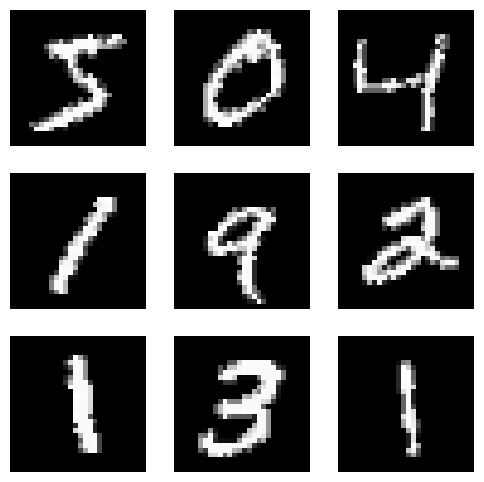

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Выводим каждую картинку на своем месте

    tensor_to_pil = tfs.ToPILImage()
    img = tensor_to_pil(doubled_dataset[i][0])
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # отключаем оси координат

plt.show()

### Преобразованные картинки

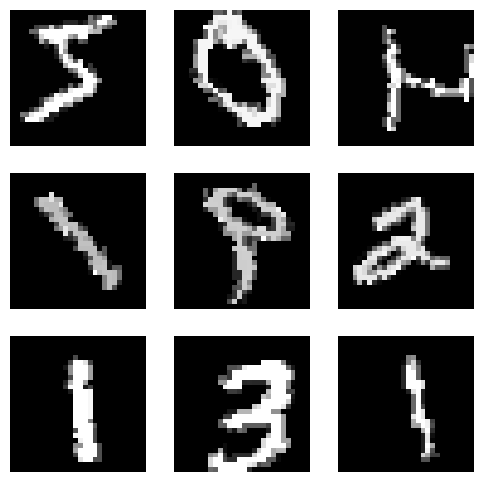

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Выводим каждую картинку на своем месте

    tensor_to_pil = tfs.ToPILImage()
    img = tensor_to_pil(doubled_dataset[60000 + i][0])
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # отключаем оси координат

plt.show()

In [19]:
activation = nn.ReLU()
model = nn.Sequential(
    # nn.Flatten преобразует входные данные, двумерный тензор,
    #в одномерный тензор путем "сплющивания" всех осей на входном тензоре, кроме первой.
    nn.Flatten(),
    # линейный слой со 784 признаками на входе и 256 на выходе
    nn.Linear(28 * 28, 256),
    # функция активации ReLU
    activation,
    # линейный слой со 256 признаками на входе и 128 на выходе
    nn.Linear(256, 128),
    # функция активации ReLU
    activation,
    # линейный слой со 128 признаками на входе и 64 на выходе
    nn.Linear(128, 64),
    # функция активации ReLU
    activation,
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

In [20]:
# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7297916666666666
Loader: valid. Accuracy: 0.935
Epoch: 2
Loader: train. Accuracy: 0.8755583333333333
Loader: valid. Accuracy: 0.9569
Epoch: 3
Loader: train. Accuracy: 0.9062583333333334
Loader: valid. Accuracy: 0.9658
Epoch: 4
Loader: train. Accuracy: 0.9205583333333334
Loader: valid. Accuracy: 0.9682
Epoch: 5
Loader: train. Accuracy: 0.9286833333333333
Loader: valid. Accuracy: 0.9767
Epoch: 6
Loader: train. Accuracy: 0.93445
Loader: valid. Accuracy: 0.9766
Epoch: 7
Loader: train. Accuracy: 0.9398083333333334
Loader: valid. Accuracy: 0.9772
Epoch: 8
Loader: train. Accuracy: 0.9439
Loader: valid. Accuracy: 0.976
Epoch: 9
Loader: train. Accuracy: 0.945725
Loader: valid. Accuracy: 0.9752
Epoch: 10
Loader: train. Accuracy: 0.9478916666666667
Loader: valid. Accuracy: 0.9792


Получили, хоть и немного, но более высокую точность. Поэтому можем говорить о том, что ***аугментация*** в данном случае ***работает***.  

### Задача 3(4 балла)

***CIFAR-10***: Этот датасет содержит 60000 цветных изображений 32x32 в 10 классах, таких как "самолет", "автомобиль", "птица", "кот", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик".

Параметр `num_workers` в DataLoader классе библиотеки PyTorch определяет количество подпроцессов, которые будут использоваться для загрузки данных. Когда `num_workers` больше 0, данные будут загружаться параллельно в нескольких подпроцессах. Это может значительно ускорить загрузку данных, особенно если у вас большой объем данных или если загрузка изображений или применение преобразований занимает много времени.

In [47]:
# Задаем преобразования для изображений
transform = tfs.Compose([
    tfs.ToTensor(),  # Преобразуем изображение в тензор
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализуем изображение
])

# Аугментация данных
augmentation = tfs.Compose([
    tfs.ToTensor(),
    tfs.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)), # Случайные аффинные преобразования
    tfs.ColorJitter(brightness=0.1, contrast=0.1), # Искажения яркости и контраста
    tfs.RandomHorizontalFlip(p=0.3), # Горизонтальное отражение с вероятностью 0.1
    tfs.Normalize((0.5), (0.5))
])

# Загружаем CIFAR-10 датасет для обучения
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=augmentation, download=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
doubled_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])



train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [65]:
len(doubled_dataset)

100000

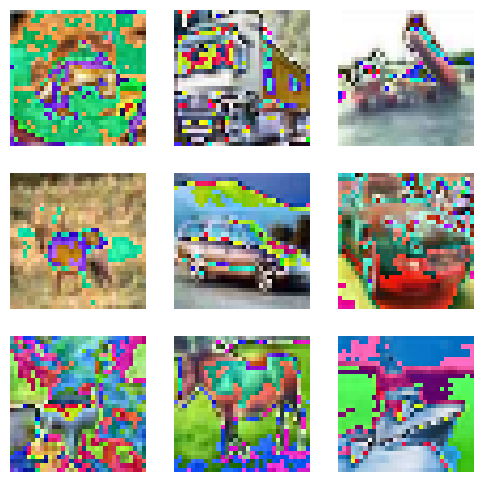

In [64]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Выводим каждую картинку на своем месте

    tensor_to_pil = tfs.ToPILImage()
    img = tensor_to_pil(doubled_dataset[i][0])
    ax.imshow(img)
    ax.axis('off')  # отключаем оси координат

plt.show()

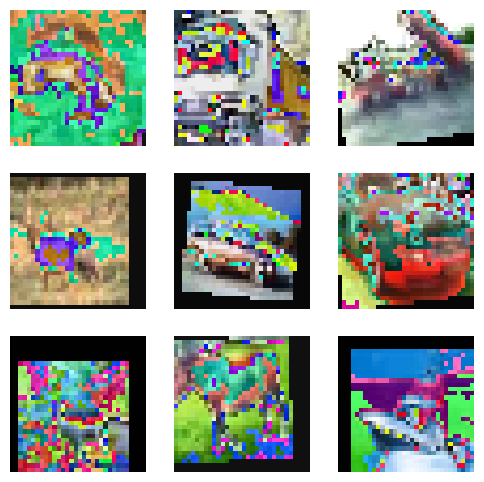

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    # Выводим каждую картинку на своем месте

    tensor_to_pil = tfs.ToPILImage()
    img = tensor_to_pil(doubled_dataset[50000 + i][0])
    ax.imshow(img)
    ax.axis('off')  # отключаем оси координат

plt.show()

### Задача 4(5 баллов)

1. Выведите несколько изображений датасета CIFAR-10
2. Произведите аугментацию данных:
3. Выведите несколько "аугментированных" изображений
4. Используя аугментированный и исходный датасет, постройте и обучите нейронную сеть.
5. Постарайтесь достичь точности порядка 60%.

P.S в данной задаче хорошую точность дают свёрточные сети, а не полносвязные, но об этом в следующей лабораторной.

In [52]:
activation = nn.Tanh()
model = nn.Sequential(
    # nn.Flatten преобразует входные данные, двумерный тензор,
    #в одномерный тензор путем "сплющивания" всех осей на входном тензоре, кроме первой.
    nn.Flatten(),
    # линейный слой со 784 признаками на входе и 256 на выходе
    nn.Linear(28 * 28, 256),
    # функция активации ReLU
    activation,
    # линейный слой со 256 признаками на входе и 128 на выходе
    nn.Linear(256, 128),
    # функция активации ReLU
    activation,
    # линейный слой со 128 признаками на входе и 64 на выходе
    nn.Linear(128, 64),
    # функция активации ReLU
    activation,
    # линейный слой со 64 признаками на входе и 10 на выходе
    nn.Linear(64, 10)
)

In [53]:
# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор - то что обновляет веса модели(model.parameters)
optimizer = torch.optim.Adam(model.parameters())
# словарь для удобства вывода результатов
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
# число эпох
max_epochs = 10
# словарь для хранения точности на обучающей и на тестовой выборке(valid)
accuracy = {"train": [], "valid": []}
# итерируемся по датасету столько раз, сколько число эпох
for epoch in range(max_epochs):
    # k принимает два значения - train и valid
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        # выбираем batch из выборки, по нему и будем делать оптимизациооный шаг
        for x_batch, y_batch in dataloader:
            if k == "train":
                # переходим в "режим обучения"
                model.train()
                # обнуляем градиенты модели
                optimizer.zero_grad()
                # выходные значения модели
                outp = model(x_batch)
                # считаем функцию потерь
                loss = criterion(outp, y_batch)
                # считаем градиенты
                loss.backward()
                # делаем шаг градиентного спуска
                optimizer.step()
            else:
                # переходим в "режим тестирования"
                model.eval()
                # отключение вычисления и хранения градиентов
                with torch.no_grad():
                    outp = model(x_batch)
            # вычисляем точность
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
        # выводим точность
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7707666666666667
Loader: valid. Accuracy: 0.9489
Epoch: 2
Loader: train. Accuracy: 0.8916333333333334
Loader: valid. Accuracy: 0.9657
Epoch: 3
Loader: train. Accuracy: 0.9121666666666667
Loader: valid. Accuracy: 0.9719
Epoch: 4
Loader: train. Accuracy: 0.9246416666666667
Loader: valid. Accuracy: 0.9651
Epoch: 5
Loader: train. Accuracy: 0.93175
Loader: valid. Accuracy: 0.9767
Epoch: 6
Loader: train. Accuracy: 0.9349083333333333
Loader: valid. Accuracy: 0.9756
Epoch: 7
Loader: train. Accuracy: 0.9410833333333334
Loader: valid. Accuracy: 0.9682
Epoch: 8
Loader: train. Accuracy: 0.9415833333333333
Loader: valid. Accuracy: 0.9746
Epoch: 9
Loader: train. Accuracy: 0.9433583333333333
Loader: valid. Accuracy: 0.9774
Epoch: 10
Loader: train. Accuracy: 0.9450833333333334
Loader: valid. Accuracy: 0.9778
